# Лабораторна робота 2
## Базові алгоритми класифікації з використанням бібліотеки sklearn
### Щербакова Валерія, ФІ-71
Dataset: https://www.kaggle.com/jacobbaruch/basketball-players-stats-per-season-49-leagues

### Провести навчання і класифікацію даних. Виконати наступні процедури:

In [2]:
import numpy as np, pandas as pd, seaborn as sb, dabl
import os, pandas as pd, matplotlib as mpl, sklearn as skl
from sklearn import linear_model as slm, model_selection as slms
from sklearn import metrics as sklm, ensemble as skle, preprocessing as sklp
from sklearn import neighbors as skln, tree as sklt, svm as skls
from matplotlib import pyplot as plt

### 1) Завантажити дані, вивести на екран назви колонок і розмір датасета

In [3]:
data = pd.read_csv(r'players_stats_by_season_full_details.csv')

In [4]:
print('Columns:', data.columns)
print('\nDataset size:', len(data))

Columns: Index(['League', 'Season', 'Stage', 'Player', 'Team', 'GP', 'MIN', 'FGM',
       'FGA', '3PM', '3PA', 'FTM', 'FTA', 'TOV', 'PF', 'ORB', 'DRB', 'REB',
       'AST', 'STL', 'BLK', 'PTS', 'birth_year', 'birth_month', 'birth_date',
       'height', 'height_cm', 'weight', 'weight_kg', 'nationality',
       'high_school'],
      dtype='object')

Dataset size: 53798


Для числовых регрессий интересны в первую очередь колонки с числовыми данными.

Сокращения описывают следующую информацию об игроке:
* `GP.` = Games Played
* `MIN` = Minutes Played
* `FGM` = Field Goals Made
* `FGA` = Field Goals Attempts
* `3PM` = Three Points Made
* `3PA` = Three Points Attempts
* `FTM` = Free Throws Made
* `FTA` = Free Throws Attempts
* `TOV` = Turnovers
* `PF.` = Personal Fouls
* `ORB` = Offensive Rebounds
* `DRB` = Defensive Rebounds
* `REB` = Rebounds
* `AST` = Assists
* `STL` = Steals
* `BLK` = Blocks
* `PTS` = Points

### 2) Опрацювати пропуски (по можливості заповнити їх або видалити)

In [5]:
c_null_cols, c_null_pcts, c_null_cnts = [], [], []
for c in data.columns:
    nulls = 100*np.mean(data[c].isnull())
    if nulls > 0:
        c_null_cols.append(c)
        c_null_pcts.append(nulls)
        c_null_cnts.append(int(nulls*len(data)/100))
    
pd.DataFrame(c_null_pcts, index=c_null_cols, columns=['% missing']).T

,Team,birth_year,birth_month,birth_date,height,height_cm,weight,weight_kg,nationality,high_school
% missing,0.020447,0.592959,0.592959,0.592959,0.137552,0.137552,8.487304,8.487304,0.013012,56.22328


In [6]:
pd.DataFrame(c_null_cnts + ['/',len(data)], index=c_null_cols + ['/','Total'], columns=['# missing']).T

,Team,birth_year,birth_month,birth_date,height,height_cm,weight,weight_kg,nationality,high_school,/,Total
# missing,11,319,319,319,74,74,4566,4566,7,30247,/,53798


В принципе такая информация как возраст или высота / вес могут с чем-то коррелировать.

Т.к. записей весьма много, а эта информация отсутствует в относительно небольшом количестве из них, 
я просто могу выбросить те записи, где этой информации нет.

In [7]:
cdata = data.dropna(subset=['birth_year', 'height_cm', 'weight_kg'])

Для анализа я оставила только нужные колонки и посчитала примерный возраст

In [8]:
adata = cdata[['GP','MIN','FGM','FGA','3PM','3PA','FTM','FTA','TOV','PF','ORB','DRB','REB','AST','STL','BLK','PTS',
               'birth_year', 'height_cm', 'weight_kg']]
bdata = data[['GP','MIN','FGM','FGA','3PM','3PA','FTM','FTA','TOV','PF','ORB','DRB','REB','AST','STL','BLK','PTS']]
pd.set_option('mode.chained_assignment', None)
adata[['birth_year']] -= 2021
adata[['birth_year']] *= -1
adata = adata.rename(columns={'birth_year': 'age', 'height_cm': 'height', 'weight_kg': 'weight'})

### 3а) Візуалізувати дані: побудувати графік (heatmap), що відображає кореляції ознак між собою і з цільовою змінною (розміткою)

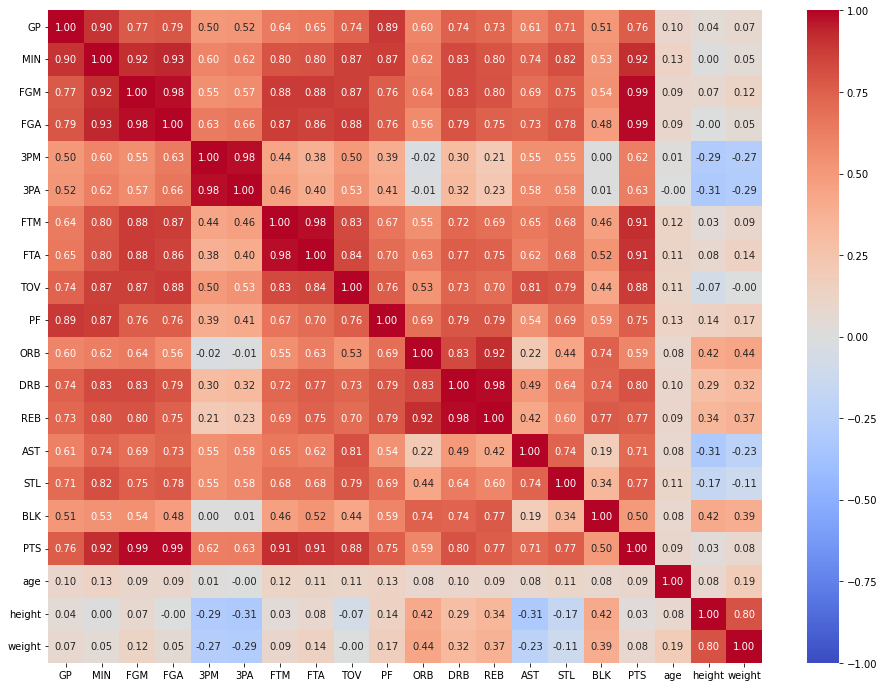

In [9]:
plt.figure(figsize=(16,12))
sb.heatmap(adata.corr(), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1.0, vmax=1.0)
plt.show()

Я заметила, что по данным видно заметную корреляцию большинства данных между собой в центральном блоке.

Отдельно выделяется стоблец трехочковых (**3PM, 3PA**), корреляция которого весьма слабая с остальными данными, особенно это заметно на примере отбираний мяча после попытки гола (**ORB, DRB, REB**) и блокирований попыток закидывания голов (**BLK**).

В качестве целевого значения я выбрала количество полученных игроком очков **PTS**.

Я решила классифицировать игроков по количеству набраных ими очков.

Я отношу в разные классы игроков с <200, 200-400, 400-800, 800-1600 и 1600+ очков.

In [10]:
def classify(row):
    crit = row['PTS']
    if crit < 200: return 0
    if crit < 400: return 1
    if crit < 800: return 2
    if crit < 1600: return 3
    return 4

data['class'] = data.apply(lambda row: classify(row), axis=1)
for i in range(0, 5):
    print(str(i)+": ", data[data['class'] == i].count()["class"])

0:  21388
1:  18935
2:  10738
3:  2394
4:  343


Рассмотрев корреляции между `PTS` и другими столбцами, я решила использовать следующие данные:

* `FGA` = Field Goals Attempts
* `3PA` = Three Points Attempts
* `FTA` = Free Throws Attempts

Выходные данные - класс `class`, к которому принадлежит игрок в зависимости от количества его очков `PTS`.

In [11]:
feature_names = ['FGA','FTA','3PA']
X = np.array(data[feature_names])
Y = np.array(data[['class']])

### 3б) побудувати гістограми розподілу ознак і boxplot-и ознак відносно цільової змінної (якщо ознак занадто багато обмежитися декількома)

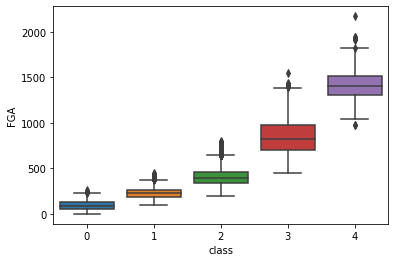

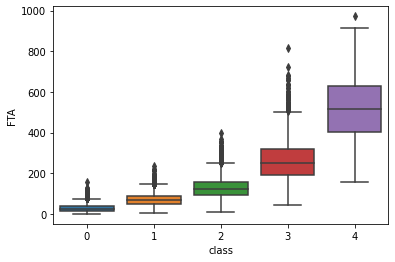

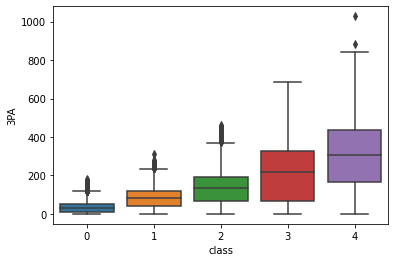

In [12]:
for i in range(len(feature_names)):
    figure = plt.figure()
    ax = sb.boxplot(x='class', y=feature_names[i], data=data)

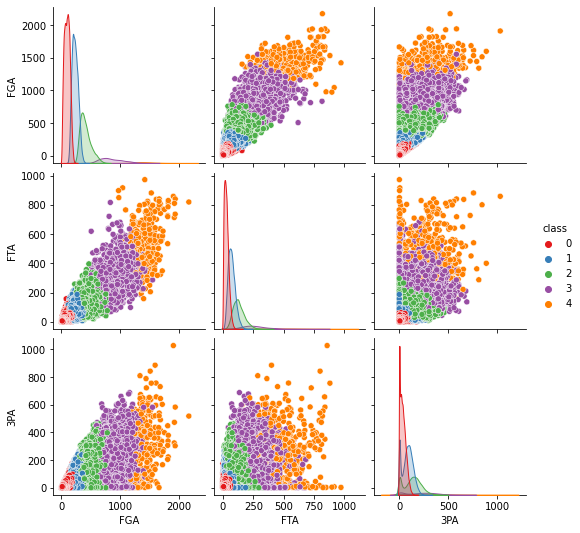

In [13]:
sb.pairplot(data[feature_names + ['class']], hue="class", palette = 'Set1')

Разделяю данные на тренировочные и тестовые

In [14]:
train_X, test_X, train_Y, test_Y = slms.train_test_split(X, Y, test_size=0.5, random_state=2021_10_25)
train_Y = np.ravel(train_Y)
test_Y = np.ravel(test_Y)

### 4) нормалізувати дані

In [16]:
scal = sklp.StandardScaler()
scal.fit(train_X)

train_XS = scal.transform(train_X)
test_XS = scal.transform(test_X)

### 5а) провести навчання наступних класифікаторів

#### kNN

In [17]:
knn = skln.KNeighborsClassifier(n_neighbors=5)
knn.fit(train_XS, train_Y)
pred_Y_knn = knn.predict(test_XS)

In [119]:
print(sklm.classification_report(test_Y, pred_Y_knn))
print('Confusion matrix: (accuracy score: ' + str(sklm.accuracy_score(test_Y, pred_Y_knn)) + ')')
sklm.confusion_matrix(test_Y, pred_Y_knn)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     10664
           1       0.88      0.88      0.88      9537
           2       0.88      0.89      0.89      5362
           3       0.91      0.89      0.90      1176
           4       0.90      0.87      0.88       160

    accuracy                           0.91     26899
   macro avg       0.90      0.90      0.90     26899
weighted avg       0.91      0.91      0.91     26899

Confusion matrix: (accuracy score: 0.9076173835458567)


array([[10021,   643,     0,     0,     0],
       [  599,  8417,   521,     0,     0],
       [    0,   489,  4786,    87,     0],
       [    0,     0,   109,  1051,    16],
       [    0,     0,     0,    21,   139]])

#### дерево прийняття рішень і візуалізувати його

In [19]:
dtc = sklt.DecisionTreeClassifier(criterion='gini')
dtc.fit(train_XS, train_Y)
pred_Y_dtc = dtc.predict(test_XS)

In [118]:
print(sklm.classification_report(test_Y, pred_Y_dtc))
print('Confusion matrix: (accuracy score: ' + str(sklm.accuracy_score(test_Y, pred_Y_dtc)) + ')')
sklm.confusion_matrix(test_Y, pred_Y_dtc)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     10664
           1       0.86      0.85      0.86      9537
           2       0.86      0.87      0.86      5362
           3       0.88      0.87      0.87      1176
           4       0.85      0.82      0.83       160

    accuracy                           0.89     26899
   macro avg       0.87      0.87      0.87     26899
weighted avg       0.89      0.89      0.89     26899

Confusion matrix: (accuracy score: 0.8877281683333953)


array([[9930,  734,    0,    0,    0],
       [ 760, 8128,  649,    0,    0],
       [   0,  578, 4667,  117,    0],
       [   0,    0,  130, 1023,   23],
       [   0,    0,    0,   29,  131]])

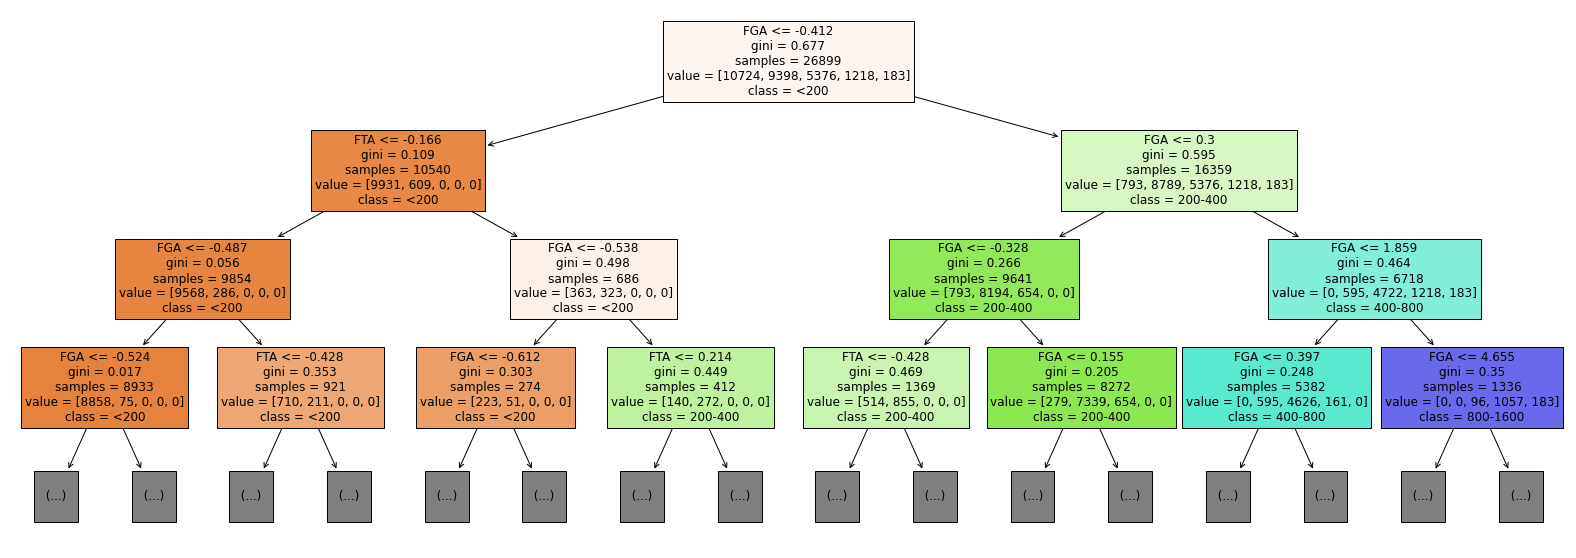

In [21]:
plt.figure(figsize = (28, 10))
sklt.plot_tree(dtc, feature_names = feature_names, 
               class_names = ['<200', '200-400', '400-800', '800-1600', '>1600'], 
               filled = True, max_depth=3, fontsize=12)
plt.show()

In [22]:
r = sklt.export_text(dtc, feature_names=feature_names)
print('\n'.join(r.split('\n')[:30]) + '\n' + ('.' * 80))

|--- FGA <= -0.41
|   |--- FTA <= -0.17
|   |   |--- FGA <= -0.49
|   |   |   |--- FGA <= -0.52
|   |   |   |   |--- FGA <= -0.58
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- FGA >  -0.58
|   |   |   |   |   |--- 3PA <= -0.94
|   |   |   |   |   |   |--- FTA <= -0.31
|   |   |   |   |   |   |   |--- FGA <= -0.56
|   |   |   |   |   |   |   |   |--- 3PA <= -0.98
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- 3PA >  -0.98
|   |   |   |   |   |   |   |   |   |--- FTA <= -0.56
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- FTA >  -0.56
|   |   |   |   |   |   |   |   |   |   |--- 3PA <= -0.97
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |   |   |   |--- 3PA >  -0.97
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- FGA >  -0.56
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |

#### SVM

In [23]:
svm = skls.SVC(C=1.0, gamma = 1.0, kernel = 'rbf')
svm.fit(train_XS, train_Y)
pred_Y_svm = svm.predict(test_XS)

In [111]:
print(sklm.classification_report(test_Y, pred_Y_svm))
print('Confusion matrix: (accuracy score: ' + str(sklm.accuracy_score(test_Y, pred_Y_svm)) + ')')
sklm.confusion_matrix(test_Y, pred_Y_svm)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     10664
           1       0.90      0.90      0.90      9537
           2       0.90      0.90      0.90      5362
           3       0.92      0.90      0.91      1176
           4       0.91      0.87      0.89       160

    accuracy                           0.92     26899
   macro avg       0.91      0.90      0.91     26899
weighted avg       0.92      0.92      0.92     26899

Confusion matrix: (accuracy score: 0.9189560950221198)


array([[10118,   546,     0,     0,     0],
       [  521,  8570,   446,     0,     0],
       [    0,   458,  4833,    71,     0],
       [    0,     0,   103,  1059,    14],
       [    0,     0,     0,    21,   139]])

#### Random Forest

In [25]:
rfc = skle.RandomForestClassifier(n_estimators=100, random_state=2021_10_25)
rfc.fit(train_XS, train_Y)
pred_Y_rfc = rfc.predict(test_XS)

In [112]:
print(sklm.classification_report(test_Y, pred_Y_rfc))
print('Confusion matrix: (accuracy score: ' + str(sklm.accuracy_score(test_Y, pred_Y_rfc)) + ')')
sklm.confusion_matrix(test_Y, pred_Y_rfc)

              precision    recall  f1-score   support

           0       0.95      0.94      0.94     10664
           1       0.89      0.89      0.89      9537
           2       0.90      0.90      0.90      5362
           3       0.91      0.90      0.91      1176
           4       0.93      0.86      0.89       160

    accuracy                           0.92     26899
   macro avg       0.92      0.90      0.91     26899
weighted avg       0.92      0.92      0.92     26899

Confusion matrix: (accuracy score: 0.9151641324956318)


array([[10059,   605,     0,     0,     0],
       [  572,  8510,   455,     0,     0],
       [    0,   431,  4851,    80,     0],
       [    0,     0,   106,  1060,    10],
       [    0,     0,     0,    23,   137]])

#### AdaBoost

In [27]:
abc = skle.AdaBoostClassifier()
abc.fit(train_XS, train_Y)
pred_Y_abc = abc.predict(test_XS)

In [113]:
print(sklm.classification_report(test_Y, pred_Y_abc))
print('Confusion matrix: (accuracy score: ' + str(sklm.accuracy_score(test_Y, pred_Y_abc)) + ')')
sklm.confusion_matrix(test_Y, pred_Y_abc)

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     10664
           1       0.62      0.93      0.75      9537
           2       0.67      0.13      0.22      5362
           3       0.88      0.69      0.78      1176
           4       0.92      0.74      0.82       160

    accuracy                           0.76     26899
   macro avg       0.81      0.69      0.70     26899
weighted avg       0.77      0.76      0.72     26899

Confusion matrix: (accuracy score: 0.7585040336071973)


array([[9857,  807,    0,    0,    0],
       [ 631, 8904,    2,    0,    0],
       [   0, 4584,  709,   69,    0],
       [   0,    7,  344,  814,   11],
       [   0,    0,    0,   41,  119]])

### 5б) Підібрати оптимальні параметри для

#### kNN

CPU times: user 20.3 s, sys: 453 ms, total: 20.8 s
Wall time: 20.8 s


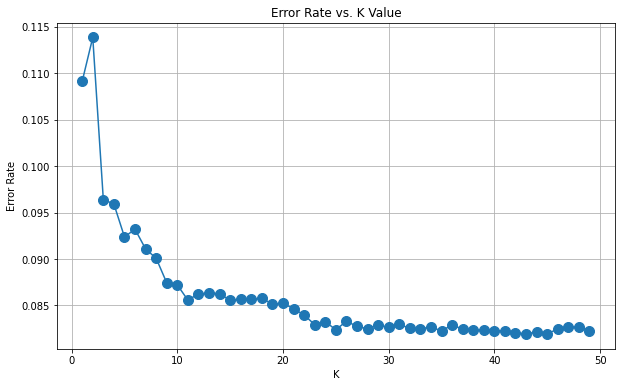

In [51]:
%%time
error_rate = []

for i in range(1,50):
    knn = skln.KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_XS, train_Y)
    pred_i = knn.predict(test_XS)
    error_rate.append(np.mean(pred_i != test_Y))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,50), error_rate, marker='o', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.grid()

In [30]:
knnB = skln.KNeighborsClassifier(n_neighbors=25)
knnB.fit(train_XS, train_Y)
pred_Y_knnB = knnB.predict(test_XS)

In [114]:
print(sklm.classification_report(test_Y, pred_Y_knnB))
print('Confusion matrix: (accuracy score: ' + str(sklm.accuracy_score(test_Y, pred_Y_knnB)) + ')')
sklm.confusion_matrix(test_Y, pred_Y_knnB)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     10664
           1       0.89      0.90      0.90      9537
           2       0.90      0.90      0.90      5362
           3       0.92      0.89      0.91      1176
           4       0.89      0.83      0.86       160

    accuracy                           0.92     26899
   macro avg       0.91      0.89      0.90     26899
weighted avg       0.92      0.92      0.92     26899

Confusion matrix: (accuracy score: 0.9176177553068887)


array([[10081,   583,     0,     0,     0],
       [  510,  8589,   438,     0,     0],
       [    0,   468,  4834,    60,     0],
       [    0,     0,   114,  1046,    16],
       [    0,     0,     0,    27,   133]])

#### для SVM за допомогою GridSearch підібрати оптимальні «C» і «gamma»

In [46]:
%%time
grid_svm = slms.GridSearchCV(skls.SVC(), {
    'C': [0.1, 1, 10, 100, 1000], 
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'kernel': ['rbf']
}, refit=True, n_jobs=8)
grid_svm.fit(train_XS, train_Y)

CPU times: user 2.23 s, sys: 250 ms, total: 2.48 s
Wall time: 1min 21s


GridSearchCV(estimator=SVC(), n_jobs=8,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']})

In [47]:
grid_svm.best_params_, grid_svm.best_estimator_

({'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}, SVC(C=1000, gamma=0.01))

In [115]:
best_svm = grid_svm.best_estimator_
pred_Y_svm_grid = best_svm.predict(test_XS)
print(sklm.classification_report(test_Y, pred_Y_svm_grid))
print('Confusion matrix: (accuracy score: ' + str(sklm.accuracy_score(test_Y, pred_Y_svm_grid)) + ')')
sklm.confusion_matrix(test_Y, pred_Y_svm_grid)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     10664
           1       0.90      0.90      0.90      9537
           2       0.90      0.90      0.90      5362
           3       0.92      0.90      0.91      1176
           4       0.88      0.88      0.88       160

    accuracy                           0.92     26899
   macro avg       0.91      0.91      0.91     26899
weighted avg       0.92      0.92      0.92     26899

Confusion matrix: (accuracy score: 0.9192535038477266)


array([[10145,   519,     0,     0,     0],
       [  539,  8556,   442,     0,     0],
       [    0,   465,  4823,    74,     0],
       [    0,     0,    94,  1062,    20],
       [    0,     0,     0,    19,   141]])

#### за допомогою GridSearch підібрати оптимальні параметри для Random Forest

In [81]:
%%time
grid_rfc = slms.GridSearchCV(sklt.DecisionTreeClassifier(), {
    'criterion': ['entropy', 'gini'],
    'max_depth': [10, 20, 40, 80, 100],
    'min_samples_leaf': [1, 2, 4, 8, 16, 32, 64],
    'max_features': ['auto', 'log2', 'sqrt']
}, refit=True, n_jobs=8)
grid_rfc.fit(train_XS, train_Y)

CPU times: user 312 ms, sys: 2.97 s, total: 3.28 s
Wall time: 5.11 s


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=8,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [10, 20, 40, 80, 100],
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4, 8, 16, 32, 64]})

In [83]:
grid_rfc.best_params_, grid_rfc.best_estimator_

({'criterion': 'entropy',
  'max_depth': 10,
  'max_features': 'log2',
  'min_samples_leaf': 16},
 DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features='log2',
                        min_samples_leaf=16))

In [116]:
best_rfc = grid_rfc.best_estimator_
pred_Y_rfc_grid = best_rfc.predict(test_XS)
print(sklm.classification_report(test_Y, pred_Y_rfc_grid))
print('Confusion matrix: (accuracy score: ' + str(sklm.accuracy_score(test_Y, pred_Y_rfc_grid)) + ')')
sklm.confusion_matrix(test_Y, pred_Y_rfc_grid)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     10664
           1       0.85      0.88      0.86      9537
           2       0.87      0.82      0.85      5362
           3       0.88      0.88      0.88      1176
           4       0.87      0.80      0.83       160

    accuracy                           0.89     26899
   macro avg       0.88      0.86      0.87     26899
weighted avg       0.89      0.89      0.89     26899

Confusion matrix: (accuracy score: 0.8907394326926652)


array([[9997,  667,    0,    0,    0],
       [ 608, 8395,  534,    0,    0],
       [   0,  850, 4400,  112,    0],
       [   0,    1,  116, 1040,   19],
       [   0,    0,    0,   32,  128]])

#### за допомогою GridSearch підібрати оптимальні параметри для AdaBoost

In [58]:
%%time
grid_abc = slms.GridSearchCV(skle.AdaBoostClassifier(), {
    'base_estimator': [sklt.DecisionTreeClassifier(), dtc, rfc],
    'n_estimators': [20, 35, 50, 65],
    'learning_rate': [0.05, 0.075, 0.1, 0.125]
}, refit=True, n_jobs=8)
grid_abc.fit(train_XS, train_Y)

CPU times: user 1min 43s, sys: 15.2 s, total: 1min 58s
Wall time: 15min 9s


GridSearchCV(estimator=AdaBoostClassifier(), n_jobs=8,
             param_grid={'base_estimator': [DecisionTreeClassifier(),
                                            DecisionTreeClassifier(),
                                            RandomForestClassifier(random_state=20211025)],
                         'learning_rate': [0.05, 0.075, 0.1, 0.125],
                         'n_estimators': [20, 35, 50, 65]})

In [59]:
grid_abc.best_params_, grid_abc.best_estimator_

({'base_estimator': RandomForestClassifier(random_state=20211025),
  'learning_rate': 0.1,
  'n_estimators': 65},
 AdaBoostClassifier(base_estimator=RandomForestClassifier(random_state=20211025),
                    learning_rate=0.1, n_estimators=65))

In [117]:
best_abc = grid_abc.best_estimator_
pred_Y_abc_grid = best_abc.predict(test_XS)
print(sklm.classification_report(test_Y, pred_Y_abc_grid))
print('Confusion matrix: (accuracy score: ' + str(sklm.accuracy_score(test_Y, pred_Y_abc_grid)) + ')')
sklm.confusion_matrix(test_Y, pred_Y_abc_grid)

              precision    recall  f1-score   support

           0       0.95      0.94      0.95     10664
           1       0.89      0.89      0.89      9537
           2       0.89      0.91      0.90      5362
           3       0.91      0.90      0.90      1176
           4       0.91      0.84      0.88       160

    accuracy                           0.92     26899
   macro avg       0.91      0.90      0.90     26899
weighted avg       0.92      0.92      0.92     26899

Confusion matrix: (accuracy score: 0.9161307111788543)


array([[10070,   594,     0,     0,     0],
       [  547,  8521,   469,     0,     0],
       [    0,   422,  4862,    78,     0],
       [    0,     0,   108,  1055,    13],
       [    0,     0,     0,    25,   135]])

### 6) Серед обраних оптимальних моделей кожного класу вибрати найкращу.
**Відобразити sklearn.metrics.classification_report і sklearn.metrics.confusion_matrix**

In [93]:
print('    method | accuracy score')
print('-----------+-------------------')
k = ''
rank = {}
for k in globals():
    if k.startswith('pred_Y_'): 
        rank[k[7:]] = sklm.accuracy_score(globals()[k], test_Y)
        
for k in dict(sorted(rank.items(), key=lambda item: item[1], reverse=True)):
    print(k.rjust(10), '|', rank[k])

    method | accuracy score
-----------+-------------------
  svm_grid | 0.9192535038477266
       svm | 0.9189560950221198
      knnB | 0.9176177553068887
  abc_grid | 0.9161307111788543
       rfc | 0.9151641324956318
       knn | 0.9076173835458567
  rfc_grid | 0.8907394326926652
       dtc | 0.8877281683333953
       abc | 0.7585040336071973


Лучшими оказались `svm_grid`, `knnB` и `abc_grid`. Просто `svm` тоже показал очень хороший результат.

In [110]:
print('SVM', grid_svm.best_params_)
print(sklm.classification_report(test_Y, pred_Y_svm_grid))
print(sklm.confusion_matrix(test_Y, pred_Y_svm_grid))

print(('-'*60)+'\nKNN', {'n_neighbors': 25})
print(sklm.classification_report(test_Y, pred_Y_knnB))
print(sklm.confusion_matrix(test_Y, pred_Y_knnB))

print(('-'*60)+'\nABC', grid_abc.best_params_)
print(sklm.classification_report(test_Y, pred_Y_abc_grid))
print(sklm.confusion_matrix(test_Y, pred_Y_abc_grid))

SVM {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     10664
           1       0.90      0.90      0.90      9537
           2       0.90      0.90      0.90      5362
           3       0.92      0.90      0.91      1176
           4       0.88      0.88      0.88       160

    accuracy                           0.92     26899
   macro avg       0.91      0.91      0.91     26899
weighted avg       0.92      0.92      0.92     26899

[[10145   519     0     0     0]
 [  539  8556   442     0     0]
 [    0   465  4823    74     0]
 [    0     0    94  1062    20]
 [    0     0     0    19   141]]
------------------------------------------------------------
KNN {'n_neighbors': 25}
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     10664
           1       0.89      0.90      0.90      9537
           2       0.90      0.90      0.90      